In [1]:
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiPoint, Polygon, box
from shapely import get_coordinates
from shapely import centroid
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image

In [2]:
def house_centers(data):
    data['centers'] = [centroid(row) for row in data.geometry]#geometry
    return data
    
def house_inhabitants(data):
    
    data['Total_inhabit'] = [row*3 if row>0 else 0 for row in data.Apartments]
    data['Kids_kindergarden'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Kids_school'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Retired'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Adults_cars'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Adults_public'] = [row*.45 if row>0 else 0 for row in data.Total_inhabit]
    data['Adults_mobil'] = [row*.1 if row>0 else 0 for row in data.Total_inhabit]
    return data


def select_roads_foot(df, borders_df, polygon):
    df = pd.concat([df, borders_df], ignore_index=True)
    df['ok'] = [str(polygon.intersection(row)) for row in df.geometry] 
    df = df[df['ok']!='LINESTRING Z EMPTY']
    df = df[df['Foot']==1]
    return df
def select_roads_no_foot(df, borders_df, polygon):
    df = pd.concat([df, borders_df], ignore_index=True)
    df['ok'] = [str(polygon.intersection(row)) for row in df.geometry] 
    df = df[df['ok']!='LINESTRING Z EMPTY']
    df = df[df['Foot']==0]
    return df

def select_objects(df, borders_df, polygon):
    df = pd.concat([df, borders_df], ignore_index=True)
    df['ok'] = [str(polygon.intersection(row)) for row in df.geometry] 
    df['ok'] = [0 if row[-5:]=='EMPTY' else 1 for row in df['ok']]
    df = df[df['ok'] ==1]
    return df

def save_fig(df, figsize, fname):
    plot = df.plot(figsize = figsize)
    fig = plot.get_figure()
    #fig.savefig(f"{fname}.png") #save RGB pic
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert the canvas to a numpy array (RGB)
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
    plt.close(fig)

    # Convert to grayscale using the standard formula
    gray_image = image[:,:,2]#
    gray_image = np.where(gray_image < 253, 0, gray_image)
       
    return gray_image#binary_image

def save_fig_1(df, figsize, fname):
    plot = df.plot(figsize = figsize)
    fig = plot.get_figure()
    #fig.savefig(f"{fname}.png") #save RGB pic
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert the canvas to a numpy array (RGB)
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
    plt.close(fig)

    # Convert to grayscale using the standard formula
    
       
    return image#binary_image
    

In [3]:
def select_region(xy_min, xy_max, z):
    coords = ((xy_min[0]-z, xy_min[1]-z), (xy_min[0]-z, xy_max[1]+z),  (xy_max[0]+z, xy_max[1]+z), (xy_max[0]+z, xy_min[1]-z),(xy_min[0]-z, xy_min[1]-z))
    polygon = Polygon(coords)
    points = []
    for point in coords:
        points.append(Point(point))
    #создаем временный датафрейм для добавления к фреймам объектов
    border_points = {'geometry': points}
    borders_df = pd.DataFrame.from_dict(border_points)
    return borders_df, polygon
    

In [4]:
def convert_pic_to_speed_matrix(arr, speed_0, speed_1):
    arr = np.where(arr!=0, speed_0, speed_1)
    return arr

In [5]:
#dijkstra - big map with diagonals adjusted for diaonals length

def dijkstra_map (matrix, start, end, verbose=1):
    if verbose>0: 
        print(f'Leg start - {start}, route end: {end}')
    m, n = matrix.shape
    # Create a priority queue to store (cost, position) tuples
    pq = [(matrix[start], start)]
    # Create a distance matrix to store the minimum time to reach each cell
    dist = np.full((m, n), np.inf)
    dist[start] = matrix[start]
    # Create a predecessor matrix to store the path
    predecessor = np.full((m, n), None, dtype=object)
    # Directions for moving to adjacent cells (right, down, left, up, and diagonals)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    
    while pq:
        current_cost, (x, y) = heapq.heappop(pq)
        # If we have reached the destination, construct the path
        if (x, y) == end:
            path = []
            while (x is not None)&(y is not None):
                path.append((x, y))
                
                if predecessor[x, y] is not None:
                    x, y = predecessor[x, y]
                else:
                    x, y = None,None
                
            path.reverse()
            return current_cost, path
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < m and 0 <= ny < n:
                new_cost = current_cost + (matrix[nx, ny] + matrix[x, y])*(np.sqrt(dx**2+dy**2))/2
                if new_cost < dist[nx, ny]:
                    dist[nx, ny] = new_cost
                    predecessor[nx, ny] = (x, y)
                    heapq.heappush(pq, (new_cost, (nx, ny)))
    
    # If there's no valid path (which shouldn't happen in a grid), return inf
    return np.inf, []

#create timings for each square at the map - map with speed is the source
def update_map_time(df, grid_size=1):
    return np.divide(grid_size,df)

def create_greyscale_matrix(matrix):
    fig, ax = plt.subplots()
    ax.imshow(matrix, cmap='gray', vmin=0, vmax=25)

    return fig, ax

def color_route_on_matrix(ax, cell_width, cell_height, start_point, daily_moves, planned_route):
    # Define colors for the route
    start_color = 'green'
    daily_move_color = 'blue'
    planned_route_color = 'red'

    # Helper function to fill a cell with a color
    def fill_cell(point, color):
        y,x = point
        rect = plt.Rectangle((x * cell_width, y * cell_height), cell_width, cell_height, linewidth=1, edgecolor=color, facecolor=color)
        ax.add_patch(rect)

    # Fill the start point
    fill_cell(start_point, start_color)
    
    # Fill the daily moves
    for move in daily_moves:
        fill_cell(move, daily_move_color)
    
    # Fill the planned route
    for move in planned_route:
        fill_cell(move, planned_route_color)
    
    return ax

# Example usage
#m, n = 100, 100  # Example matrix size

In [6]:
# реперные точки для рисунков
def create_rectangle(point, half_width, half_height):
    x, y = point.x, point.y
    return box(x - half_width, y - half_height, x + half_width, y + half_height)


def create_polygons(xy_min, xy_max, z1):
    coords1 =  ((xy_min[0]-z1, xy_min[1]-z1), (xy_min[0]-z1, xy_max[1]+z1),  (xy_max[0]+z1, xy_max[1]+z1), (xy_max[0]+z1, xy_min[1]-z1),(xy_min[0]-z1, xy_min[1]-z1))
    points = []
    gdf = gpd.GeoDataFrame()
    for point in coords1:
        print(point)
        #points.append(Point(point))
        tmp = gpd.GeoDataFrame(geometry=[Point(point)])#, crs="EPSG:4326"
        gdf = pd.concat([gdf, tmp], ignore_index=True) 

        # Apply the function to create a rectangle around each point
    gdf['rectangle'] = gdf.geometry.apply(create_rectangle, half_width=half_width, half_height=half_height)




    #check_points = {'geometry': points}
    #check_points_df = pd.DataFrame.from_dict(check_points)
    #check_points_df#['Foot'] = 1

    check_points_df = gdf
    check_points_df['geometry'] = check_points_df['rectangle']
    check_points_df['rectangle'] = 1
    return check_points_df
#check_points_df = create_polygons(xy_min, xy_max, z1)
#check_points_df

In [17]:
def drop_empty_from_array(arr):
    filtered_arr = arr[~(pd.isnull(arr) | (arr == None))]
    return filtered_arr


In [27]:
#Выбрать из базы метро
def select_metro(df):
    metro_list = drop_empty_from_array(df.Text.unique())
    metro = df[df.Text.isin(metro_list)]
    return metro

In [18]:
#Выбрать из базы остановки
def select_stops(df):
    substrings = ['остановка']
    # Combine substrings into a single regular expression pattern
    pattern = '|'.join(substrings)
    # Select rows where 'City' column contains any of the substrings
    filtered_df = df[df.TrType.str.contains(pattern, case=False, na=False)]

    return filtered_df

In [125]:
figsize = (20,20) #select size of picture and thus matrix
#выбираем максимальную площадь карты для рассчетов (на перспективу) с запасом +-z
z = 800
z1 = 800
half_width = 0.01
half_height = 0.01

In [126]:
fnames = ['Streets_исходные.shp', "Дома_исходные.shp", 'Выходы_метро.shp', 'Остановки_ОТ.shp', "House_1очередь_ЖК.shp",'Streets_1очередь.shp','Streets_2очередь.shp',"House_2очередь_ЖК.shp",'Streets_3очередь.shp',"House_3очередь_ЖК.shp"]

In [127]:
#Находим интересующие нас размеры
path = os.getcwd()+"/vector/"
combined = pd.DataFrame()
extension = ["House_1очередь_ЖК.shp","House_2очередь_ЖК.shp","House_3очередь_ЖК.shp"]
for item in extension :
    file_path = path+item  # Укажи путь к твоему файлу
    tmp = gpd.read_file(path+item)
    combined = pd.concat([combined, tmp], ignore_index=True)

#смотрим координаты крайних точек строящихся объектов (домов) на карте
xy_min = np.min(get_coordinates(combined.geometry), axis=0)
xy_max = np.max(get_coordinates(combined.geometry), axis=0)

print(xy_min[0], xy_min[1])
print(xy_min[0], xy_max[1])
print(xy_max[0], xy_min[1])
print(xy_max[0], xy_max[1])

4171713.34 7467405.39
4171713.34 7469492.95
4174304.47 7467405.39
4174304.47 7469492.95


In [128]:
#создаем полигон с расширенными координатами для выборки из слоев добавляя полосы шириной z 
#по краям и датафрейм для добавления (нормирования)
borders_df, polygon = select_region(xy_min, xy_max, z)
borders_df

,geometry
0,POINT (4170913.34 7466605.39)
1,POINT (4170913.34 7470292.95)
2,POINT (4175104.47 7470292.95)
3,POINT (4175104.47 7466605.39)
4,POINT (4170913.34 7466605.39)


C:\Users\andre\miniconda3\envs\python\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\andre\OneDrive\Desktop\0-Rojects\2024-International/vector/Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<AxesSubplot: >

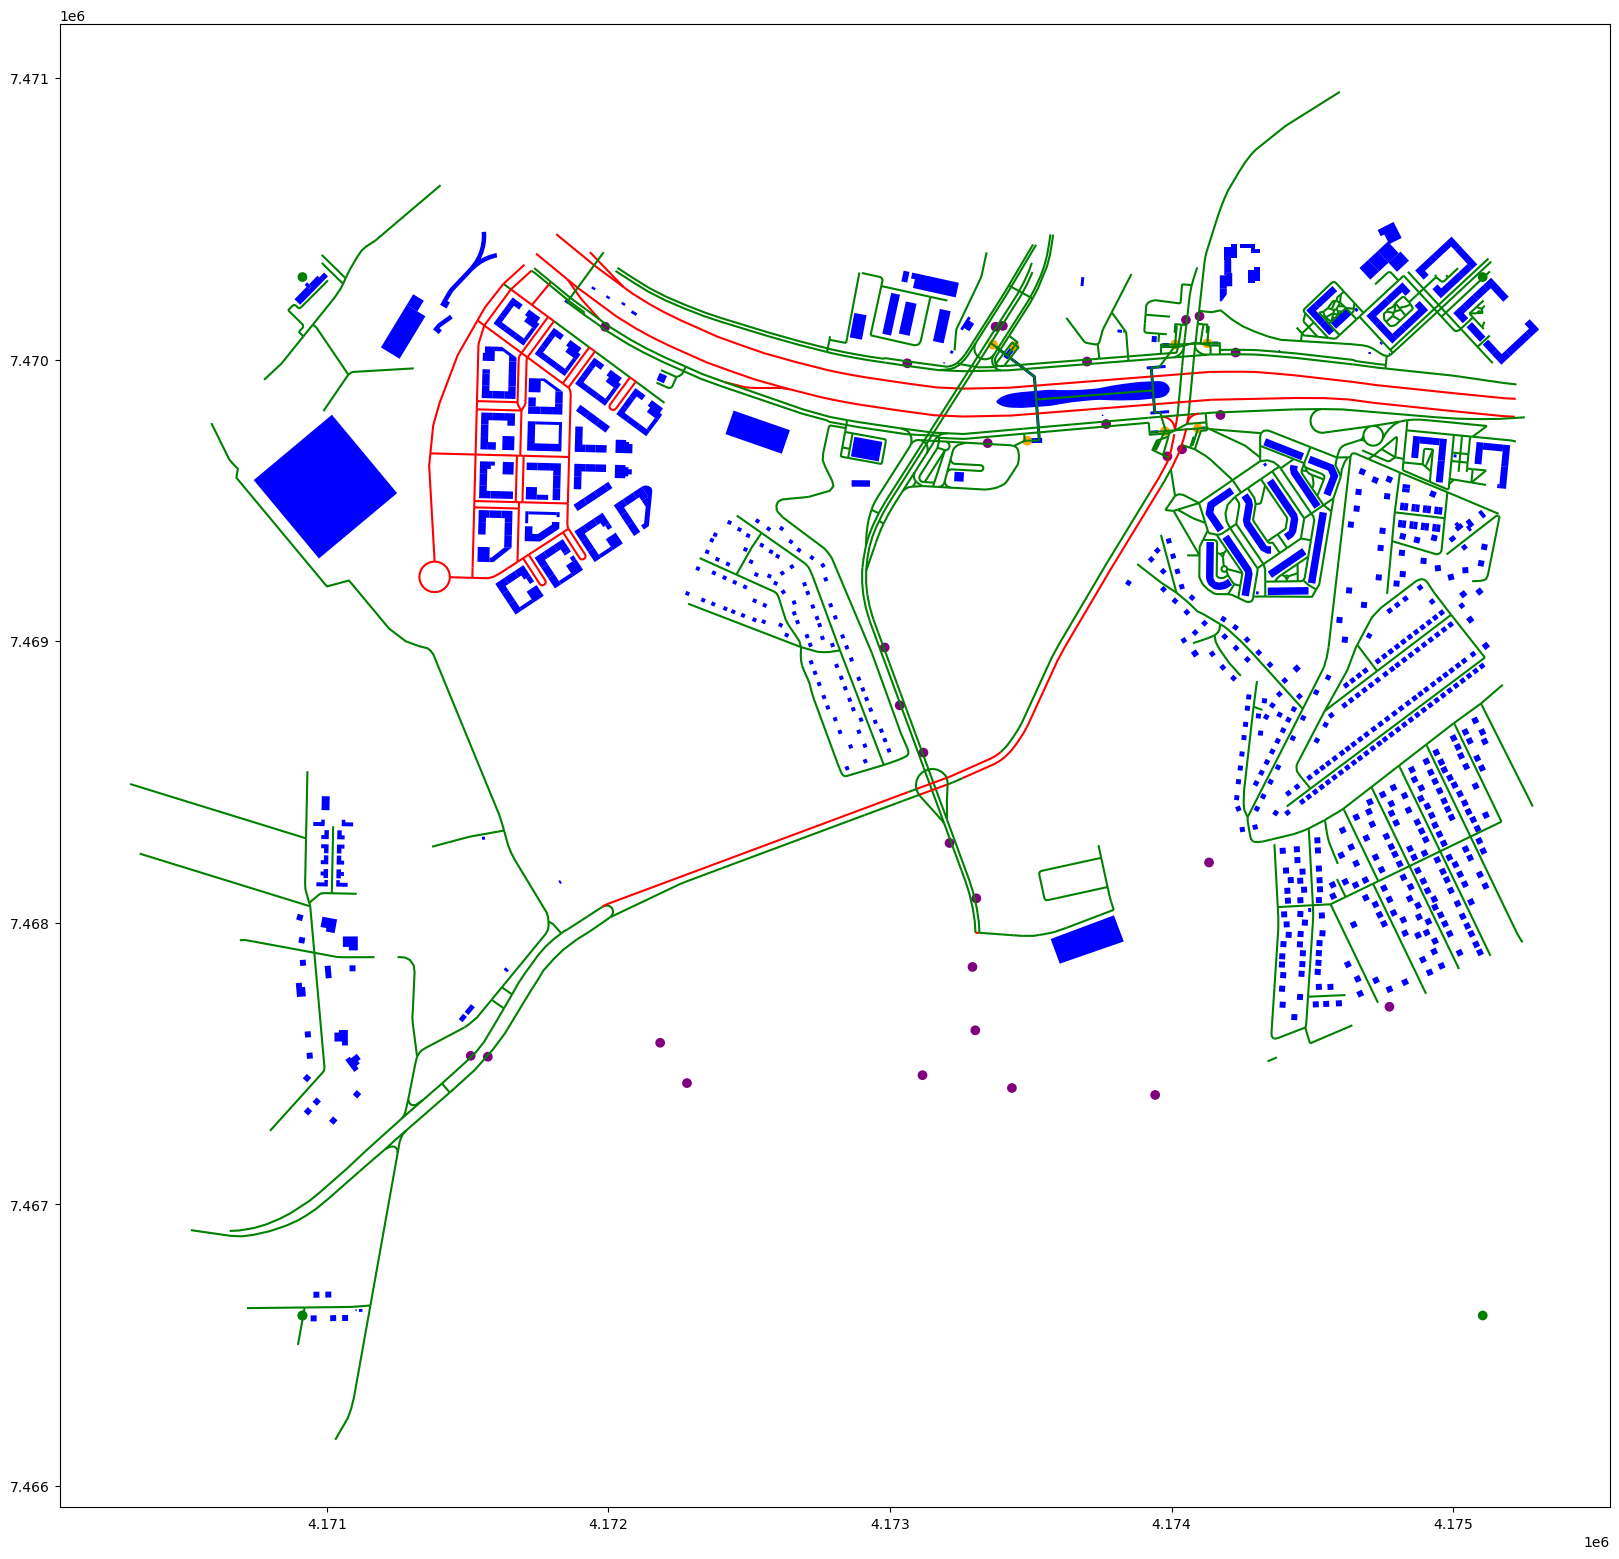

In [129]:

# Загрузка данных из файла .shp - исходная ситуация
path = os.getcwd()+"/vector/"
colors = ['red', 'green', 'purple', 'orange']
file_path = path+'Дома_исходные.shp'  # Укажи путь к твоему файлу
data1 = gpd.read_file(file_path)
data1['color'] = 'blue'
file_path = path+'Streets_исходные.shp'  # Укажи путь к твоему файлу
data2 = gpd.read_file(file_path)
data2['color'] = [colors[row] for row in data2.Foot]
file_path = path+'Выходы_метро.shp'  # Укажи путь к твоему файлу
data3 = gpd.read_file(file_path)
data3['color'] = colors[3]
file_path = path+'Остановки_ОТ.shp'  # Укажи путь к твоему файлу
data4 = gpd.read_file(file_path)
data4['color'] = colors[2]

combined = pd.concat([data1, data2, data3, data4], ignore_index = True)

# Отображение данных на карте
#colors = ['blue', 'green', 'purple', 'orange']

#data.plot(column='color', cmap='Set1', legend=True, figsize = (20,50))
#combined.plot(color = combined['color'], figsize = figsize)

#Добавляем реперные точки для лучшего видения и выделяем только объекты в нужном регионе

df = select_objects(combined, borders_df, polygon)
df = df.reset_index()
df['color'] = df['color'].fillna('green')
df.plot(color = df['color'], figsize = figsize)
#fig, ax = plt.subplots(figsize=figsize)  # Set figure size
#df1.plot(ax=ax, color=df1.color, markersize=1)  # Adjust marker color and size
#plt.axis('off')

In [130]:


file_path = path+"House_1очередь_ЖК.shp"  # Укажи путь к твоему файлу
data_1 = gpd.read_file(file_path)
data_1['color'] = 'blue'
file_path = path+'Streets_1очередь.shp'  # Укажи путь к твоему файлу
data_2 = gpd.read_file(file_path)
data_2['color'] = [colors[row] for row in data_2.Foot]
combined = pd.concat([combined, data_1, data_2], ignore_index = True)

df1 = select_objects(combined, borders_df, polygon)
df1 = df1.reset_index()
df1['color'] = df1['color'].fillna('green')
#df1.plot(color = df1['color'], figsize = figsize)
fig, ax = plt.subplots(figsize=figsize)  # Set figure size
df1.plot(ax=ax, color=df1.color, markersize=1)  # Adjust marker color and size
plt.axis('off')

(4170051.02, 4175554.98, 7465925.0065, 7471189.9035)

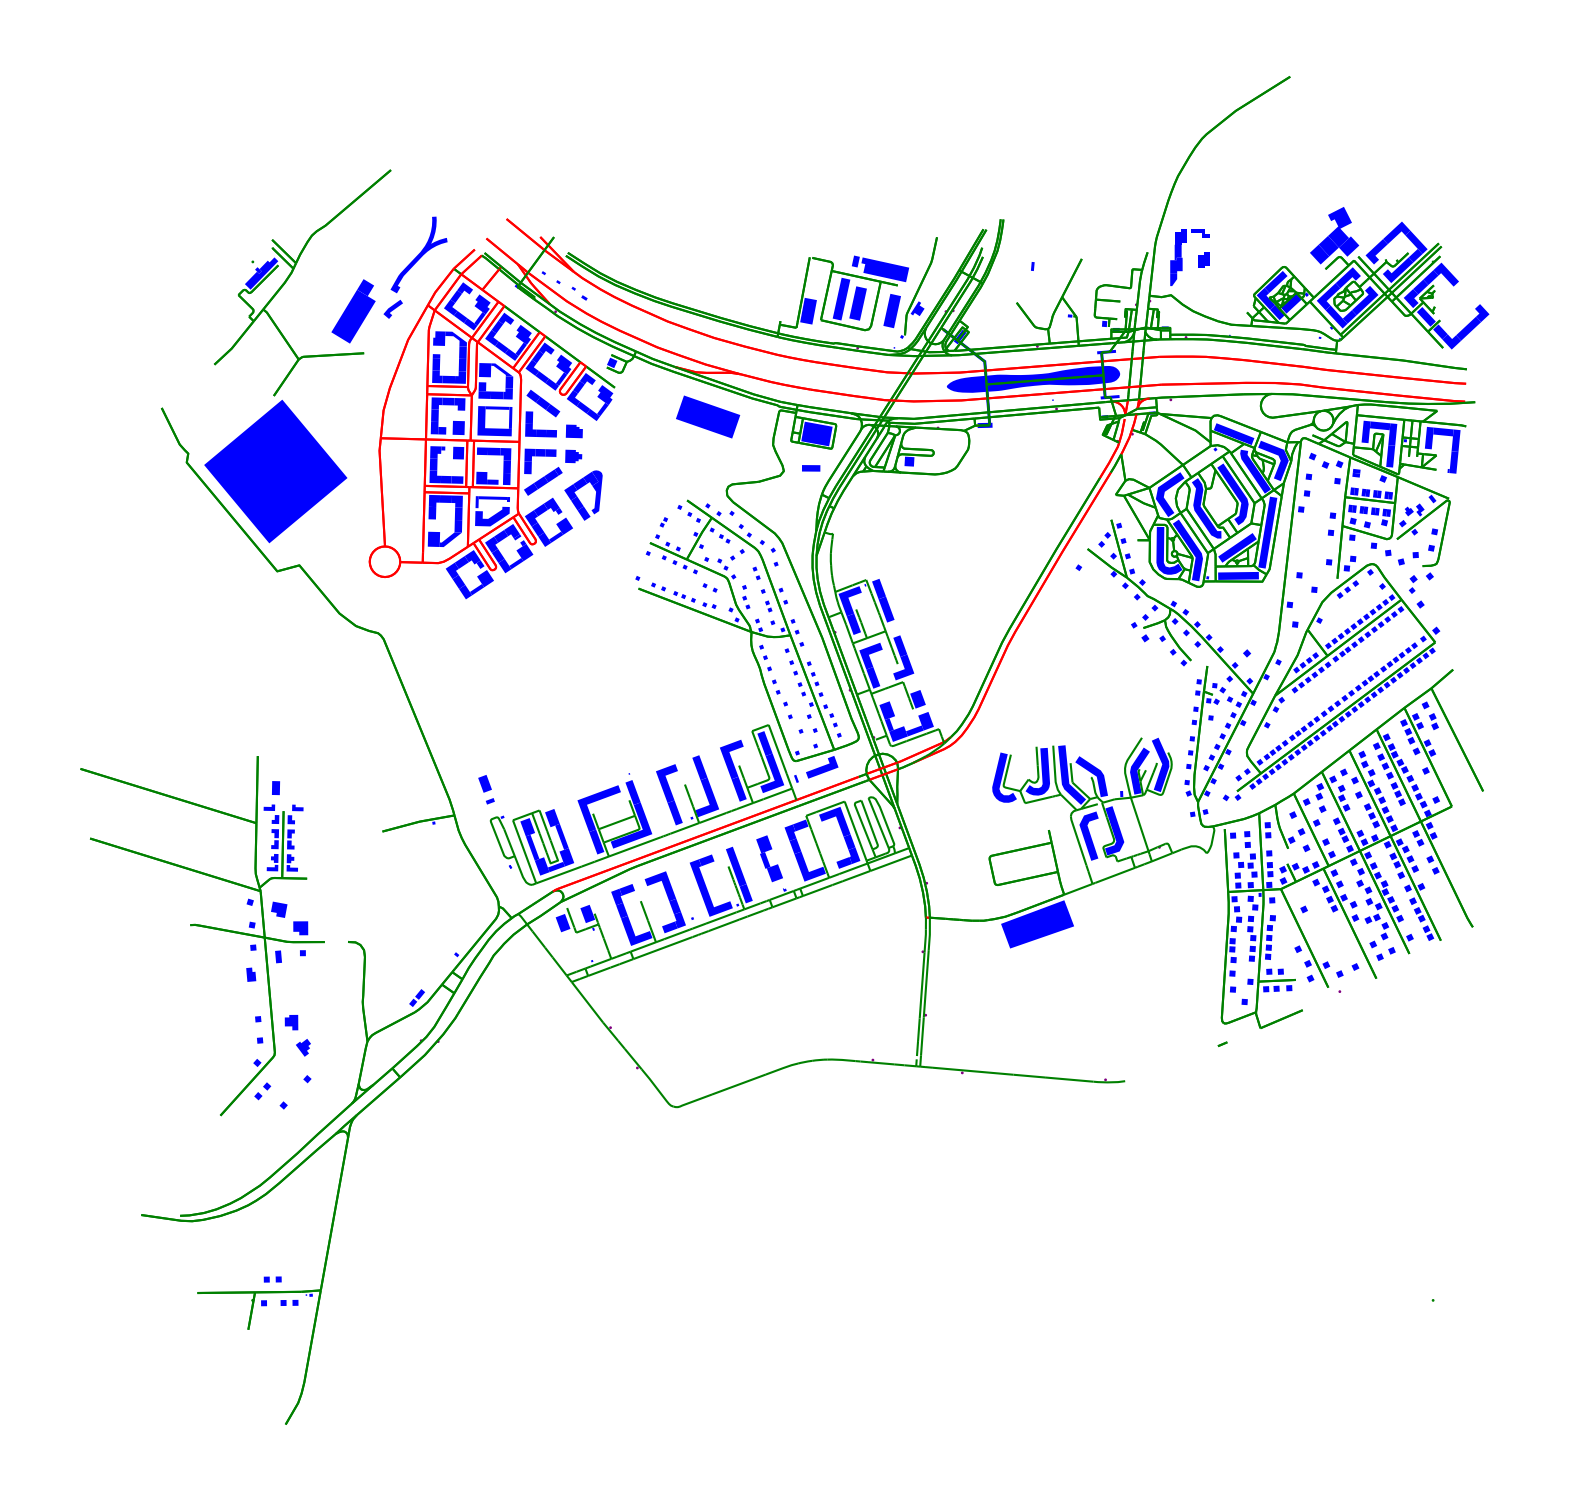

In [146]:
df1 = house_centers(df1)
df1.centers
houses = df1[(df1.Type == 'Жилые дома')&(df1.index>1000)]
houses.geometry = houses.centers
schools = df1[df1.Type == 'Школы']
schools.geometry = schools.centers
kinder_g = df1[df1.Type == 'Дошкольные']
kinder_g.geometry =kinder_g.centers
stops = select_stops(df1)
metro = select_metro(df1)
print(f'Number of houses in vicinity - {len(houses)}')
print(f'Number of schools in vicinity - {len(schools)}')
print(f'Number of kindergardens in vicinity - {len(kinder_g)}')
print(f'Number of metro entrances in vicinity - {len(metro)}')
print(f'Number of bus stops in vicinity - {len(stops)}')

Number of houses in vicinity - 30
Number of schools in vicinity - 1
Number of kindergardens in vicinity - 1
Number of metro entrances in vicinity - 7
Number of bus stops in vicinity - 29


C:\Users\andre\miniconda3\envs\python\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [149]:
schools.geometry 
kinder_g.geometry

46    POINT (4170942.166 7470252.383)
Name: centers, dtype: geometry

In [133]:
# Function to map a point's coordinates to pixel coordinates
def to_pixel_coords(x, y, x_min, x_max, y_min, y_max, width, height):
    px = int((x - x_min) / (x_max - x_min) * width)
    py = int((y_max - y) / (y_max - y_min) * height)  # Reverse y-axis for image coordinates
    return px, py

def draw_map (df):
    fig, ax = plt.subplots(figsize=figsize)  # Set figure size
    
    df1.plot(ax=ax, color=df1.color, markersize=1)  # Adjust marker color and size
    #plt.axis('off')
    fig.savefig(f"Map_local.png") #save RGB pic
    canvas = FigureCanvas(fig)
    canvas.draw()
    

    # Convert to a numpy array
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
    plt.close(fig)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Get image dimensions
    height, width, _ = (1481, 1550, 1)#image.shape поправка на ширину полей
    height = height*figsize[0]/20
    width = width*figsize[0]/20
    
    return  x_min, x_max, y_min, y_max, width, height

# Calculate pixel coordinates for each point in the GeoDataFrame - for houses and stops and 
def find_point_coordinates(df, x_min, x_max, y_min, y_max, width, height):
    band_x = 250 *figsize[0]/20#поправка на оси
    band_y = 265 *figsize[0]/20
    pixel_coords = [to_pixel_coords(point.x, point.y, x_min, x_max, y_min, y_max, width, height)
                    for point in df.geometry]
    coord = {}
    # Output the pixel coordinates
    for idx, (x, y) in enumerate(pixel_coords):
        print(f"Point {idx}: Pixel coordinates -> ({int(x+band_x)}, {int(y+band_y)})")
        coord[idx] = (int(x+band_x),int(y+band_y))
    return coord

In [134]:
x_min, x_max, y_min, y_max, width, height = draw_map (df1)
metro_coord = find_point_coordinates(metro, x_min, x_max, y_min, y_max, width, height)

Point 0: Pixel coordinates -> (1183, 584)
Point 1: Pixel coordinates -> (1204, 586)
Point 2: Pixel coordinates -> (1217, 680)
Point 3: Pixel coordinates -> (1355, 671)
Point 4: Pixel coordinates -> (1388, 668)
Point 5: Pixel coordinates -> (1397, 583)
Point 6: Pixel coordinates -> (1365, 584)


In [150]:
house_coord = find_point_coordinates(houses, x_min, x_max, y_min, y_max, width, height)
house_coord

Point 0: Pixel coordinates -> (1377, 1025)
Point 1: Pixel coordinates -> (1329, 1089)
Point 2: Pixel coordinates -> (1354, 1087)
Point 3: Pixel coordinates -> (1282, 1030)
Point 4: Pixel coordinates -> (1401, 1019)
Point 5: Pixel coordinates -> (1334, 1030)
Point 6: Pixel coordinates -> (1307, 1031)
Point 7: Pixel coordinates -> (1241, 1036)
Point 8: Pixel coordinates -> (1083, 1091)
Point 9: Pixel coordinates -> (1041, 1106)
Point 10: Pixel coordinates -> (1008, 1113)
Point 11: Pixel coordinates -> (979, 1129)
Point 12: Pixel coordinates -> (947, 1141)
Point 13: Pixel coordinates -> (827, 1168)
Point 14: Pixel coordinates -> (803, 1177)
Point 15: Pixel coordinates -> (908, 1155)
Point 16: Pixel coordinates -> (868, 1170)
Point 17: Pixel coordinates -> (973, 1022)
Point 18: Pixel coordinates -> (1010, 1020)
Point 19: Pixel coordinates -> (909, 1046)
Point 20: Pixel coordinates -> (945, 1044)
Point 21: Pixel coordinates -> (874, 1074)
Point 22: Pixel coordinates -> (835, 1068)
Point 23:

{0: (1377, 1025),
 1: (1329, 1089),
 2: (1354, 1087),
 3: (1282, 1030),
 4: (1401, 1019),
 5: (1334, 1030),
 6: (1307, 1031),
 7: (1241, 1036),
 8: (1083, 1091),
 9: (1041, 1106),
 10: (1008, 1113),
 11: (979, 1129),
 12: (947, 1141),
 13: (827, 1168),
 14: (803, 1177),
 15: (908, 1155),
 16: (868, 1170),
 17: (973, 1022),
 18: (1010, 1020),
 19: (909, 1046),
 20: (945, 1044),
 21: (874, 1074),
 22: (835, 1068),
 23: (788, 1099),
 24: (1162, 965),
 25: (1143, 915),
 26: (1111, 917),
 27: (1090, 863),
 28: (1123, 855),
 29: (1136, 979)}

In [78]:
print(x_min, x_max, y_min, y_max, width, height)

4170051.02 4175554.98 7465925.0065 7471189.9035 2000 2000


In [82]:
df1.TrStopId.unique()

array([nan, '4504282549350480', '4504282549350484', '4504282549350580',
       '4504282549350584', '70030076945308810', '70030076164525717',
       '4504282549350592', '4504282549350596', '4504282549350665',
       '70030076164524472', '70030076164525651', '70030076499065625',
       '70030076624708844'], dtype=object)

In [49]:
df1[df1.Type =='Школы']

,level_0,index,Name,Type,Caption,Purpose,PostIndex,Elevation,Entrances,Apartments,...,Foot,Car,duplicat,payment,material,length,Text,TrType,TrStopId,ok


In [158]:
# Define RGB values for each color - матрица соответствия скоростей
color_map = {
    (0, 128, 0): 1,      # Green -> 1
    (255, 0, 0): 0.2,      # Red -> 2
    (255, 255, 0): 3,    # Yellow -> 3
    (0, 0, 255): 0.1,      # Blue -> 4
    (128, 0, 128): 1,     # Purple -> 5
    (255, 255, 255): 0.5
}
image = Image.open("Map_local.png")

# Convert the image to RGB mode if not already in that mode
image = image.convert("RGB")
# Convert the image to a numpy array
image_array = np.array(image)


result_matrix = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.float32)

# Replace each color with its corresponding value - заменяем цвета
for rgb, value in color_map.items():
    print(rgb)
    mask = np.all(image_array == rgb, axis=-1)
    result_matrix[mask] = value

(0, 128, 0)
(255, 0, 0)
(255, 255, 0)
(0, 0, 255)
(128, 0, 128)
(255, 255, 255)


In [162]:
# Матрица скоростей
result_matrix
result_matrix = np.where(result_matrix==0, 0.3, result_matrix)
timings = 1./result_matrix

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

In [ ]:
#Расчет времени для всех дорожек и прорисовка дорожек

In [179]:
df['color']=df['color'].fillna('yellow')

In [180]:
df['color'].unique()

array(['blue', 'green', 'red', 'purple', 'yellow'], dtype=object)

<AxesSubplot: >

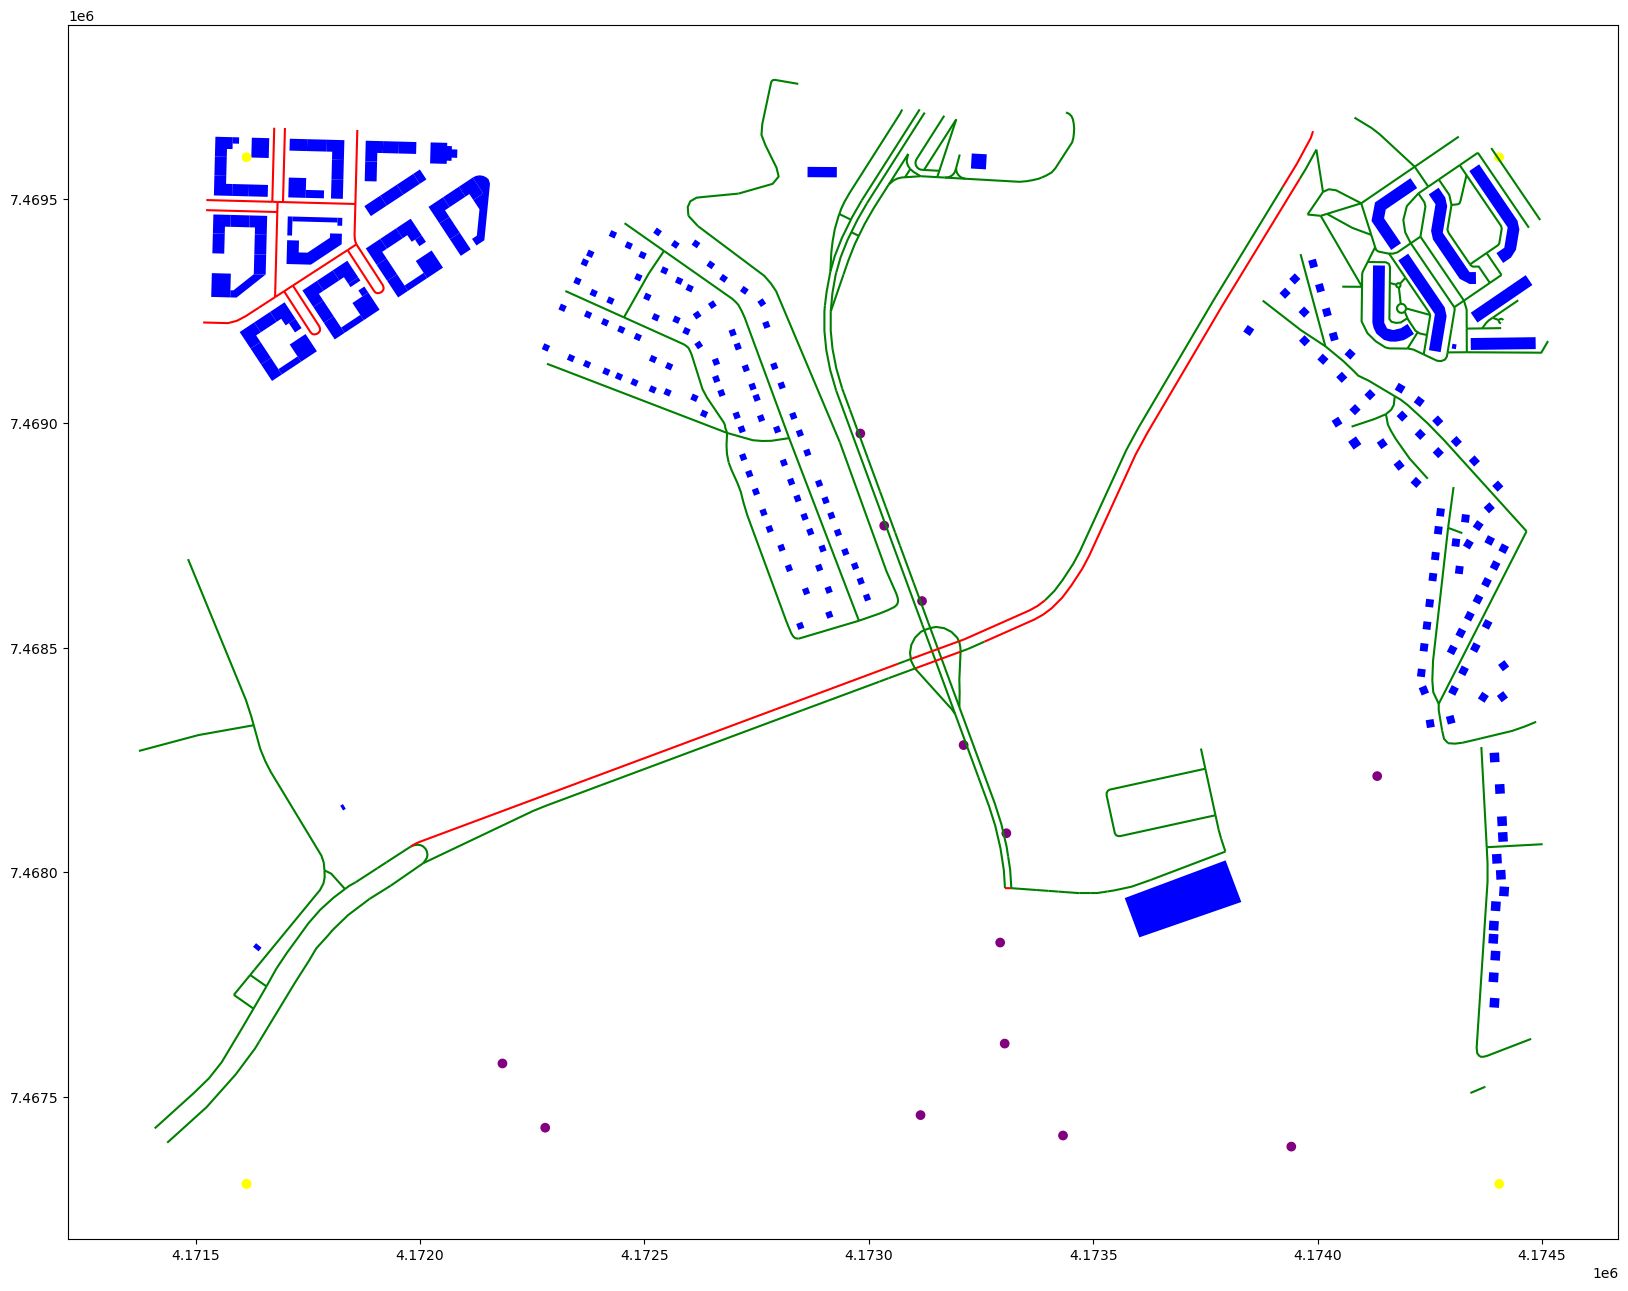

In [139]:
df.plot(color = df['color'], figsize = (20,20))

In [115]:
path = os.getcwd()+"/vector/"
combined = pd.DataFrame()
for item in fnames[:4]:
    file_path = path+item  # Укажи путь к твоему файлу
    tmp = gpd.read_file(path+item)
    combined = pd.concat([combined, tmp], ignore_index=True)

combined    

C:\Users\andre\miniconda3\envs\python\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\andre\OneDrive\Desktop\0-Rojects\2024-International/vector/Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


,EdgeId,ST_NAME,ST_TYP_BEF,ST_NM_BASE,ST_NM_CITY,FUNC_CLASS,ROAD_CATEG,F_ZLEV,T_ZLEV,TYPE_LINK,...,Street3,StreetId3,Number3,Street4,StreetId4,Number4,Material,Text,TrType,TrStopId
0,13604.0,None,None,None,None,6.0,Внутриквартальные проезды,0.0,0.0,Обычное звено,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13680.0,None,None,None,None,6.0,Внутриквартальные проезды,0.0,0.0,Обычное звено,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13686.0,None,None,None,None,6.0,Внутриквартальные проезды,0.0,0.0,Обычное звено,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13741.0,None,None,None,None,6.0,Внутриквартальные проезды,0.0,0.0,Обычное звено,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13788.0,None,None,None,None,6.0,Внутриквартальные проезды,0.0,0.0,Обычное звено,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Автобусная остановка,70030076182590875
43659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Автобусная остановка,70030076948540367
43660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Автобусная остановка,70030076948540429
43661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Автобусная остановка,70030076948540491


In [ ]:
image_array = np.array(image)

In [169]:
#image_array = save_fig_1(df, figsize, 'all')
fname = 'matrix'
plot = df.plot(color = df['color'], figsize = (20,20))
fig = plot.get_figure()
fig.savefig(f"{fname}.png") #save RGB pic
canvas = FigureCanvas(fig)
canvas.draw()

    # Convert the canvas to a numpy array (RGB)
image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
plt.close(fig)
image_array= image

In [170]:
image_array

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [174]:
result_matrix

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)

In [175]:
result_matrix
df_s = pd.DataFrame (result_matrix)

## save to xlsx file

filepath = 'speed_array_excel_file.csv'

df_s.to_csv(filepath, index=False)

In [104]:
path = os.getcwd()+"/vector/"
combined = pd.DataFrame()
for item in fnames[:6]:
    file_path = path+item  # Укажи путь к твоему файлу
    tmp = gpd.read_file(path+item)
    combined = pd.concat([combined, tmp], ignore_index=True)
combined['center'] = combined.geometry.centroid
#combined_short  
# Отображение данных на карте
#combined.plot(figsize = (200,150))

C:\Users\andre\miniconda3\envs\python\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\andre\OneDrive\Desktop\0-Rojects\2024-International/vector/Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [108]:
#создаем матрицы скоростей пешеходов для разных объектов
#для улиц - пешеходные
def pedestrian_yes_street_arr(file_path, street_file_name, check_points_df, borders_df,speed_0, speed_1):
    data = gpd.read_file(file_path)   
    data = select_roads_foot(data, borders_df, polygon)
    df_st = pd.concat([check_points_df, data], ignore_index=True)
    
    #data1 = pd.concat([data, check_points_df], ignore_index=True)
    #df_st = select_roads_foot(data1, borders_df, polygon)
    arr = save_fig(df_st, figsize, street_file_name)
    plt.imshow(arr, interpolation='nearest', aspect = 'equal')
    plt.show()
    im = Image.fromarray(arr)
    im.save("yes_foot_street.tiff")
    arr = convert_pic_to_speed_matrix(arr, speed_0, speed_1)
    return arr

#для улиц - непешеходные
def pedestrian_no_street_arr(file_path, street_file_name, check_points_df, borders_df, speed_0, speed_2):
    data = gpd.read_file(file_path)   
    data = select_roads_no_foot(data, borders_df, polygon)
    df_st = pd.concat([check_points_df, data], ignore_index=True)
    
    #data1 = pd.concat([data, check_points_df], ignore_index=True)
    #df_st = select_roads_no_foot(data1, borders_df, polygon)
    arr = save_fig(df_st, figsize, street_file_name)
    plt.imshow(arr, interpolation='nearest', aspect = 'equal')
    plt.show()
    im = Image.fromarray(arr)
    im.save("no_foot_street.tiff")
    arr = convert_pic_to_speed_matrix(arr, speed_0, speed_2)
    return arr

#для домов
def pedestrian_house_arr(file_path, house_file_name, check_points_df, borders_df, speed_0, speed_2):
    data = gpd.read_file(file_path)   
    data = select_objects(data, borders_df, polygon)
    df_st = pd.concat([check_points_df, data], ignore_index=True)
    
    #data1 = pd.concat([data, check_points_df], ignore_index=True)
    #df_st = select_objects(data1, borders_df, polygon)
    arr = save_fig(df_st, figsize, house_file_name)
    plt.imshow(arr, interpolation='nearest', aspect = 'equal')
    plt.show()
    im = Image.fromarray(arr)
    im.save("houses.tiff")
    arr = convert_pic_to_speed_matrix(arr, speed_0, speed_3)
    return arr

def pedestrian_stops_arr(file_path, stops_file_name, check_points_df, borders_df):
    data = gpd.read_file(file_path)   
    data = select_objects(data, borders_df, polygon)
    df_st = pd.concat([check_points_df, data], ignore_index=True)
    arr = save_fig(df_st, figsize, stops_file_name)
    plt.imshow(arr, interpolation='nearest', aspect = 'equal')
    plt.show()
    im = Image.fromarray(arr)
    im.save(f"{stops_file_name}.tiff")
    arr = convert_pic_to_speed_matrix(arr, speed_0, speed_3)
    return arr

In [109]:
def create_lines(xy_min, xy_max, z1):
    borders_df, polygon = select_region(xy_min, xy_max, z1)
    # Create GeoDataFrame for the points
    gdf_points = borders_df
    # Create lines connecting each consecutive point
    lines = []
    for i in range(len(gdf_points) - 1):
        point1 = gdf_points.geometry.iloc[i]
        point2 = gdf_points.geometry.iloc[i + 1]
        line = LineString([point1, point2])  # Create a line between the two points
        lines.append(line)

    # Optional: To close the loop, connect the last point back to the first
    # Uncomment the following lines if you want to form a closed polygon
    # point1 = gdf_points.geometry.iloc[-1]
    # point2 = gdf_points.geometry.iloc[0]
    # line = LineString([point1, point2])
    # lines.append(line)

    # Create a new GeoDataFrame for the lines
    gdf_lines = gpd.GeoDataFrame(geometry=lines)
    return gdf_lines 
check_points_df = create_lines(xy_min, xy_max, z1)
check_points_df

,geometry
0,"LINESTRING (4171213.34 7466905.39, 4171213.34 ..."
1,"LINESTRING (4171213.34 7469992.95, 4174804.47 ..."
2,"LINESTRING (4174804.47 7469992.95, 4174804.47 ..."
3,"LINESTRING (4174804.47 7466905.39, 4171213.34 ..."


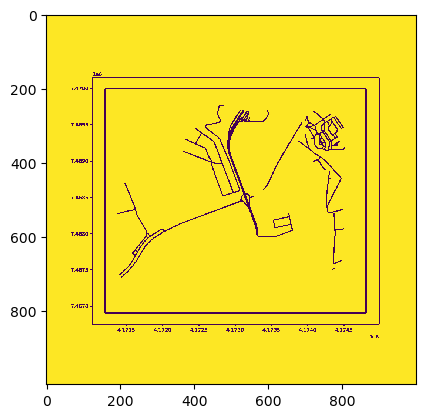

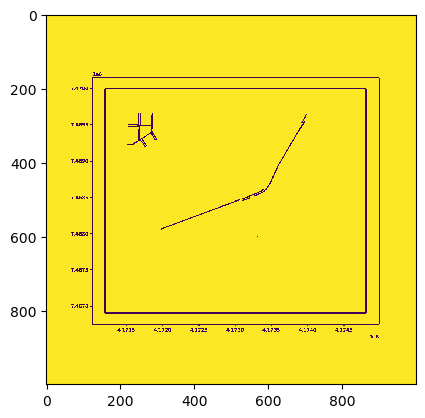

(4171213.34, 7466905.39)
(4171213.34, 7469992.95)
(4174804.47, 7469992.95)
(4174804.47, 7466905.39)
(4171213.34, 7466905.39)


C:\Users\andre\miniconda3\envs\python\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\andre\OneDrive\Desktop\0-Rojects\2024-International/vector/Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


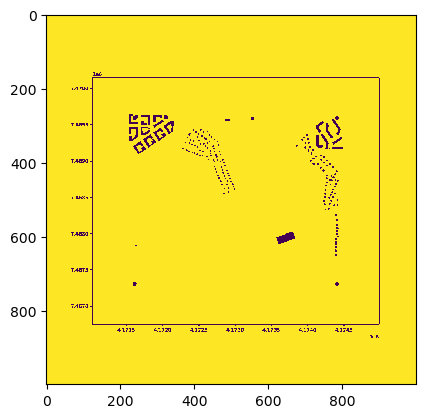

C:\Users\andre\miniconda3\envs\python\lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [110]:
speed_0 = 0 # скорость на пустыре
speed_1 = 1   # скорость на пешеходной дороге
speed_2 = 0.2 # скорость на непешеходной дороге
speed_3 = 0.1 # скорость в здании

fnamess = ['Streets_исходные.shp', "Дома_исходные.shp", 'Выходы_метро.shp', 'Остановки_ОТ.shp']


file_path = path+fnamess[0]
check_points_df = create_lines(xy_min, xy_max, z1)
arr = pedestrian_yes_street_arr(file_path, 'orig_street_y', check_points_df, borders_df,speed_0, speed_1)
#arr
file_path = path+fnamess[0]
check_points_df = create_lines(xy_min, xy_max, z1)
arr1 = pedestrian_no_street_arr(file_path, 'orig_street_n', check_points_df, borders_df,speed_0, speed_2) 
#arr1
file_path = path+fnamess[1]
check_points_df = create_polygons(xy_min, xy_max, z1)
arr2 = pedestrian_house_arr(file_path, 'buildings', check_points_df, borders_df,speed_0, speed_2) 
arr2
file_path = path+fnamess[2]
data = gpd.read_file(file_path)

data = select_objects(data, check_points_df, polygon)
data = pd.concat([data, borders_df], ignore_index=True)
arr3 = save_fig(data, figsize, 'metro')
arr3 = convert_pic_to_speed_matrix(arr3, speed_0, speed_1)
#pedestrian_stops_arr(file_path, 'metro', check_points_df)
file_path = path+fnamess[3]
data = gpd.read_file(file_path)   
data = select_objects(data, borders_df, polygon)
data = pd.concat([data, check_points_df], ignore_index=True)
arr4 = save_fig(data, figsize, 'stops')
arr4 = convert_pic_to_speed_matrix(arr4, speed_0, speed_1)
arr4

In [111]:
arr_total = arr+ arr1+ arr2 + arr3+arr4
arr_total

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [112]:
arr_total = np.where(arr_total==0, 0.5, arr_total)
arr_total

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [113]:
df_s = pd.DataFrame (arr_total)

## save to xlsx file

filepath = 'speed_array_excel_file.csv'

df_s.to_csv(filepath, index=False)

In [114]:
im = Image.fromarray(arr_total)
im.save("total.tiff")